In [1]:
from tensorflow.keras import *
from tensorflow.keras.layers import * 
import tensorflow as tf
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
tf.executing_eagerly()

True

In [2]:
cat_dict = {
        'event_name_1': {'input_dim': 31, 'output_dim': 1},
        'event_type_1': {'input_dim': 5, 'output_dim': 1},
        'event_name_2': {'input_dim': 5, 'output_dim': 1},
        'event_type_2': {'input_dim': 5, 'output_dim': 1},

        'item_id': {'input_dim': 3049, 'output_dim': 3},
        'dept_id': {'input_dim': 7, 'output_dim': 1},
        'store_id': {'input_dim': 10, 'output_dim': 1},
        'cat_id': {'input_dim': 3, 'output_dim': 1},
        'state_id': {'input_dim': 3, 'output_dim': 1},  
#         'wday': {'input_dim': 7, 'output_dim': 1}, 
#         'month': {'input_dim': 12, 'output_dim': 1}, 
#         'year': {'input_dim': 6, 'output_dim': 1}, 
#         'day': {'input_dim': 31, 'output_dim': 1}, 
           }
cat_cols = list(cat_dict.keys())


In [3]:
class build_model(object):
    def __init__(self, seq_len, dec_seq_len, num_cont_features, categorical_details={},  dec_num_layers=2, hidden_size=128, teacher_forcing=False):
        self.seq_len = seq_len
        self.dec_seq_len = dec_seq_len
        self.num_features = num_cont_features
        self.dec_hidden_size = hidden_size
        self.enc_hidden_size = hidden_size 
        self.categorical_details = categorical_details
        self.hidden_size = hidden_size
        self.teacher_forcing = teacher_forcing
        self.num_layers = dec_num_layers

    def create_cat_inputs_embeddings(self):
        catInputs = []
        embeddings_cat = []
        embed_layer_names=[]
        for feature_name, embedding_params in self.categorical_details.items():
            feature_input = Input(shape=(self.seq_len,), name=feature_name)
            catInputs.append(feature_input)
            embedding = Embedding(**embedding_params, name = f'{feature_name}_embed')(feature_input)
            embeddings_cat.append(embedding)
        return catInputs, embeddings_cat
    
    def create_encoder(self, encoder_input):
        """
        Creates encoder RNN layers 
        """
        for i in range(self.num_layers):
            if i == 0:
                output, hidden = GRU(units=self.enc_hidden_size, 
                                     return_sequences=True, return_state=True,
                                     kernel_initializer='he_normal')(encoder_input)
            else:
                output, hidden = GRU(units=self.enc_hidden_size, 
                                     return_sequences=True, return_state=True,
                                     kernel_initializer='he_normal')(output, initial_state=hidden)

        return output, hidden

    def build_encoder_model(self):
        """
        Builds entire encoder computation graph - input and categorical embedding layers to RNN layers. 
        """
        # get inputs 
        self.encoder_input_cont = Input(shape=(self.seq_len, self.num_features), name='continous_features') 
        # create embeddings for categoricals and concat features with continous features
        if self.categorical_details:
            self.catInputs, embeddings_cat = self.create_cat_inputs_embeddings()
            # input to encoder -> concatenate continous and categorial features
            encoder_input = concatenate([self.encoder_input_cont] + embeddings_cat)
        else:
            self.catInputs = []
            encoder_input = self.encoder_input_cont  
        # saving encoder state to self for inference 
        self.enc_output, self.enc_state = self.create_encoder(encoder_input=encoder_input)
        
    def create_decoder_cells(self, decoder_input, decoder_hidden):
        """
        Creates a RNN layer vertically at timestep N. 
        Inputs: 
            decoder_input is input at one timestep - shape (batch_size, 1)
            decoder_hidden: - initial hidden state at layer 0 - shape- (batch_size, hidden_size)
        output:
            (batch_size, hidden_size)
        """            
        if self.dec_hidden_size != decoder_hidden.shape[-1] or len(decoder_hidden.shape)>2:
            raise ValueError('Hidden size is {} but decoder input has shape {}'.format(dec_hidden_size, decoder_hidden.shape))
#         print('decoder input shape {} and decoder hidden shape {} '.format(decoder_input.shape, decoder_hidden.shape))
        for i in range(self.num_layers):
            out, decoder_hidden = GRUCell(units=self.dec_hidden_size, 
                                          kernel_initializer='he_normal')(decoder_input, decoder_hidden)
            decoder_input = out

        return out, decoder_hidden

    def create_decoder(self, decoder_input, decoder_hidden): 
        """
        Creates decoder
        Input: Initial decoder hidden state. Will be passing encoder output hidden state 
        decoder input: (batch_size, dec_seq_len)
        """
        outputs = []
        if not self.teacher_forcing:
            for i in range (self.dec_seq_len):
                o, h = self.create_decoder_cells(decoder_input, decoder_hidden)
                # FC layers 
#                 o = Dense(32)(o)
                o = Dense(1, activation='relu')(o)
                outputs.append(o)
                # output of at timestep N is input at N+1
                decoder_input = o 
                # layers.GRUCell returns hidden state of type List
                decoder_hidden=h[0]
        elif True:
            print('using regular teacher forcing')
            for i in range(self.num_layers):
                if i == 0:
                    decoder_input, decoder_hidden = GRU(units=self.dec_hidden_size, 
                                         return_sequences=True, return_state=True,
                                         kernel_initializer='he_normal')(decoder_input, 
                                                                         initial_state=decoder_hidden)
            o = TimeDistributed(Dense(1, activation='relu'))(decoder_input)
            return o 
            
            
            
        else:
            for i in range(self.dec_seq_len):
                # feeding in target (decoder input) at time T into decoder at time T+1.
                # first element of sequence of decoder_input padded with zeros prior
                decoder_input_t = tf.expand_dims(decoder_input[:, i], axis=1)
#                 decoder_input_t=f.stop_gradient(decoder_input_t)
                o, h = self.create_decoder_cells(decoder_input_t, decoder_hidden)
                # layers.GRUCell returns hidden state of type List
#                 o = Dense(32)(o)
                o = Dense(1, activation='relu')(o)
                outputs.append(o)
                decoder_hidden=h[0]
#         print('dec final outputs shape ', outputs.shape)
        return tf.concat(outputs, axis=1) 


    def build_decoder_model(self):
        # creating decoder 
        if self.teacher_forcing:
            self.decoder_input = Input(shape=(self.dec_seq_len))
            self.preds = self.create_decoder(self.decoder_input, self.enc_state)
            return Model(inputs=[self.encoder_input_cont] + self.catInputs + [self.decoder_input] , 
                         outputs=self.preds)
        else:
            # shape 1 because vector used only for the first timestep of decoder 
            self.decoder_input = Input(shape=(1))
            self.preds = self.create_decoder(self.decoder_input, self.enc_state)
            return Model(inputs=[self.encoder_input_cont] + self.catInputs + [self.decoder_input], 
                         outputs=self.preds)

In [6]:
%%time
# x = np.load('train/data_x.npy', allow_pickle=True).astype(np.float32)
# y = np.load('train/data_y.npy', allow_pickle=True).astype(np.float32)
x=np.load('features/x_5000.npy', allow_pickle=True).astype(np.float32)
y=np.load('features/y_5000.npy', allow_pickle=True).astype(np.float32)
# y=np.squeeze(y, axis=-1)

with open('features/feature_names2.txt', 'r') as f:
    feature_names = f.read()
feature_names=feature_names.split(',')

print('Features shape {}, target shape {}'.format(x.shape, y.shape))

if len(feature_names) != x.shape[-1]:
    raise ValueError('Number of features in feature names not equal to saved file')

Features shape (540000, 56, 20), target shape (540000, 28)
Wall time: 1min 3s


In [7]:
def create_idx_map(features):
    mapping = {}
    for i, feat in enumerate(features):
        mapping[feat] = i
#     if len(mapping) != len(features):
#         raise ValueError('Duplicates in features. Please fix')
    return mapping

class mappings(object):
    
    """
    Object to obtain mappings of features from numpy array
    inputs: 
        features - list of features
        cont_features - list. If none, everything other than Cat is used 
        cat_features = categorical features in order of the embeddings in neural net
        target - target column

    """

    def __init__(self, features, cont_features, cat_features, target='sales'):
        self.features = features 
        # auto 
        if not cont_features:
            cont_features = list(set(features) - set(cat_features))
            
        # move target to first element
        if cont_features[0] != target:
            cont_features.insert(0, cont_features.pop(cont_features.index(target)))
        
        self.cont_features = cont_features
        self.cat_features = cat_features
        
    def create_idx_map(self, features):
        mapping = {}
        for i, feat in enumerate(features):
            mapping[feat] = i
        if len(mapping) != len(features):
            raise ValueError('Duplicates in features. Please fix')
        return mapping
        
    def get_mappings(self):
        return self.create_idx_map(self.features)
    
    def get_cat_idx(self):
        mappings = self.get_mappings()
        return [mappings[i] for i in self.cat_features]
    
    def get_cont_idx(self):
        mappings = self.get_mappings()
        idxs = [mappings[i] for i in self.cont_features]
        
        return idxs
    
maps = mappings(feature_names, None, cat_cols, target='sales')      
num_features = len(maps.get_cont_idx())

w = []
for key in cat_dict.keys():
    m = maps.get_mappings()
    idx = m[key]
    if not (x[:, :, idx] <= cat_dict[key]['input_dim']).all():
        s = x[:, :, idx][x[:, :, idx] > cat_dict[key]['input_dim']]
        w.append(s)
        print(f' index {idx} and key {key} is out of range')
    
def create_input(x, decoder_input):
    cont = maps.get_cont_idx()
    cat = maps.get_cat_idx()
    x_cat = [] 
    for idx in cat: 
        x_cat.append(x[:, :, idx])
    x_cont = x[:, :, cont]
    return [x_cont] + x_cat + [decoder_input]
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

In [ ]:
import time
from datetime import datetime
seq_len, dec_seq_len = 56, 28
batch_size = 128*3
model_ = build_model(seq_len, dec_seq_len, num_features, categorical_details=cat_dict,
                     teacher_forcing=True)

model_.build_encoder_model()
model = model_.build_decoder_model()

model.compile(optimizer='adam', loss='mean_squared_error', 
              metrics=['mae', root_mean_squared_error])
# log_dir="" + datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = "logs/{}".format(time.time())
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
embed_layer_names = [f'{key}_embed' for key in cat_dict.keys()]
tensorboard_callback = TensorBoard(
                    log_dir=log_dir,
#                     batch_size=batch_size, 
                    embeddings_freq=1,
                    update_freq='epoch',
                    write_grads=True)

es_callback = EarlyStopping(patience=3)

print('training..')
if not model_.teacher_forcing:
    decoder_input = tf.zeros((x.shape[0], 1))
    x_train = create_input(x, decoder_input)    
else:
    # padding 
    decoder_input = tf.concat([tf.zeros((x.shape[0], 1)), y[:, :-1]], axis=1)
    x_train = create_input(x, decoder_input) 

history = model.fit(x=x_train, y=y, batch_size=batch_size, 
                    epochs=30,
                    shuffle=True, validation_split=0.15, callbacks=[tensorboard_callback])

training..
Epoch 1/30
1196/1196 [==============================] - 60s 50ms/step - loss: 8.5199 - mae: 1.0565 - root_mean_squared_error: 2.7524 - val_loss: 9.3684 - val_mae: 1.0465 - val_root_mean_squared_error: 1.9883
Epoch 2/30
1196/1196 [==============================] - 58s 48ms/step - loss: 6.6082 - mae: 1.0103 - root_mean_squared_error: 2.4635 - val_loss: 8.4380 - val_mae: 1.0316 - val_root_mean_squared_error: 1.9586
Epoch 3/30
1196/1196 [==============================] - 57s 48ms/step - loss: 6.2739 - mae: 1.0041 - root_mean_squared_error: 2.4150 - val_loss: 8.0760 - val_mae: 1.0597 - val_root_mean_squared_error: 1.9462
Epoch 4/30
1196/1196 [==============================] - 58s 48ms/step - loss: 6.1248 - mae: 1.0018 - root_mean_squared_error: 2.3926 - val_loss: 7.9199 - val_mae: 1.0348 - val_root_mean_squared_error: 1.9359
Epoch 5/30
1196/1196 [==============================] - 58s 48ms/step - loss: 6.0234 - mae: 0.9984 - root_mean_squared_error: 2.3732 - val_loss: 7.8296 - val

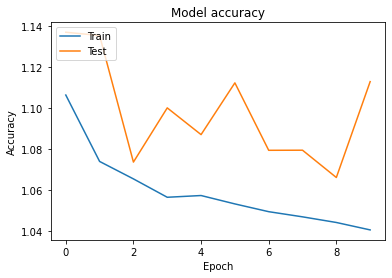

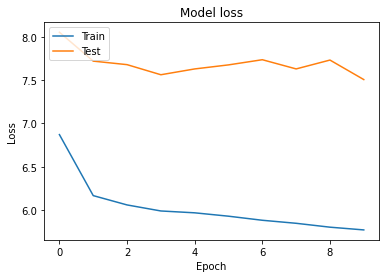

In [7]:
import matplotlib.pyplot as plt
metric = 'mae'
# Plot training & validation accuracy values
plt.plot(history.history[metric])
plt.plot(history.history[f'val_{metric}'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()